In [36]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os
import torch

from typing import cast, List
from torch import FloatTensor, Tensor
from torch.utils.data import DataLoader
from dataclasses import asdict
from einops import rearrange, repeat
from diffusers.models.autoencoders.vae import DecoderOutput
from diffusers.models.modeling_outputs import AutoencoderKLOutput
from diffusers.models.autoencoders.autoencoder_kl import AutoencoderKL

from flow_mnist.data import MNISTDataset
from flow_mnist.config import load_config
from flow_mnist.utils import plot_batch, norm2image, image2norm

In [38]:
os.chdir("..") if not os.path.exists("config.yaml") else None

torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config = load_config('config.yaml')
dataset = MNISTDataset(**asdict(config.data))

### Inspect AutoEncoderKL Output

Random sample from the dataset

In [39]:
n_samples = 10
figsize = (15, 10)

x_index = torch.randperm(len(dataset))[:n_samples].tolist()
x_batch_list = [dataset[i][0] for i in x_index]
x_batch = rearrange(x_batch_list, "b c h w -> b c h w")

Display random sample

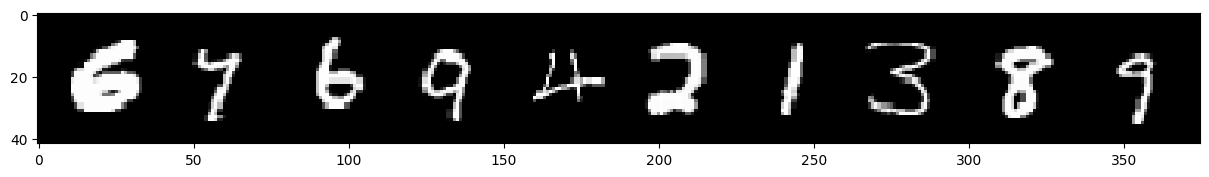

Input Size: torch.Size([10, 3, 32, 32])
Input Range: [0.00, 1.00]


In [40]:
plot_batch(x_batch, nrow=n_samples, figsize=figsize)
print(f'Input Size: {x_batch.size()}')
print(f'Input Range: [{x_batch.min():.2f}, {x_batch.max():.2f}]')

Encode-Decode the random sample using AutoEncoderKL

In [41]:
vae_kl = AutoencoderKL.from_pretrained(config.model.vae.repo).to(device)
vae_kl = vae_kl.requires_grad_(False)

x_input = x_batch.to(device)
x_input = image2norm(x_input)

x_encoded = vae_kl.encode(x=x_input)
x_encoded = cast(AutoencoderKLOutput, x_encoded)

x_latent_sample: FloatTensor = x_encoded.latent_dist.sample()

x_decoded = vae_kl.decode(z=x_latent_sample)
x_decoded = cast(DecoderOutput, x_decoded).sample

x_out = norm2image(x_decoded).cpu()

Compare Input-Output

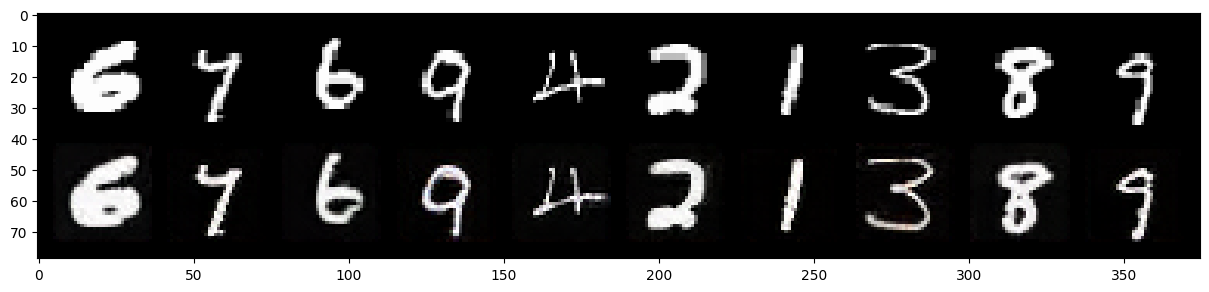

Input Size: torch.Size([10, 3, 32, 32])
Input Range: [0.00, 1.00]


In [42]:
x_diff = rearrange([x_batch, x_out], 'd b c h w -> (d b) c h w')
plot_batch(x_diff, nrow=n_samples, figsize=figsize)
print(f'Input Size: {x_batch.size()}')
print(f'Input Range: [{x_batch.min():.2f}, {x_batch.max():.2f}]')

In [43]:
latent_size = x_latent_sample.size()
print(f'Latent Size: {latent_size}')

compression_factor = 100 * x_latent_sample.nelement() / x_batch.nelement()
print(f'Compression Factor using scaled input: {compression_factor: .2f}%')

compression_factor = 100 * x_latent_sample.nelement() / (n_samples * 28**2)
print(f'Compression Factor using non-scaled input: {compression_factor: .2f}%')

Latent Size: torch.Size([10, 4, 4, 4])
Compression Factor using scaled input:  2.08%
Compression Factor using non-scaled input:  8.16%


### Compute AutoEncoderKL Scaling Factor

https://github.com/huggingface/diffusers/issues/437#issuecomment-1241827515

> We introduced the scale factor in the latent diffusion paper. The goal was to handle different latent spaces (from different autoencoders, which can be scaled quite differently than images) with similar noise schedules. The scale_factor ensures that the initial latent space on which the diffusion model is operating has approximately unit variance. Hope this helps :)

In [44]:
data_loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)
latents: List[Tensor] = []

with torch.inference_mode():
    for (X, y) in data_loader:
        X = image2norm(X.to(device))

        X_latent_dist = vae_kl.encode(X, return_dict=True)
        X_latent_dist = cast(AutoencoderKL, X_latent_dist).latent_dist
        X_latent: Tensor = X_latent_dist.sample()
        X_latent = X_latent.cpu()

        latents.append(X_latent)

X_latents = rearrange(latents, 'n b c h w -> (n b) c h w')

In [45]:
scale_factor = 1. / X_latents.std()
print(f'Scale Factor = {scale_factor.item():.5f}')

Scale Factor = 0.19374
